## This notebook demonstrates how to run MassWastingRunout on a real hillslope:
## The Cascade, 2022 landslide

In [8]:
# setup
import os

## import plotting tools
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## import necessary landlab components
from landlab import RasterModelGrid
from landlab.components import FlowAccumulator
from landlab.components import(FlowDirectorD8, 
                                FlowDirectorDINF, 
                                FlowDirectorMFD, 
                                FlowDirectorSteepest)

from landlab.components.mass_wasting_runout import MassWastingRunout

## import landlab plotting functionality
from landlab.plot.drainage_plot import drainage_plot
from landlab import imshow_grid_at_node

## import functions
from landlab.io.esri_ascii import write_esri_ascii
from landlab.io import read_esri_ascii
from landlab.io.netcdf import read_netcdf

from landlab.components import ChannelProfiler, FlowAccumulator, DepressionFinderAndRouter


### set MassWastingRunout parameters

In [9]:
# Model parameters, determined through calibration 
critical_slope = [0.15589918235700001]
threshold_flux = 0.766

# Model parameters, determined from field and DoD
erosion_coefficient = 0.0337443
typical_flow_thickness_of_erosion_zone = 2
typical_slope_of_erosion_zone = 0.25
max_flow_depth_observed_in_field = 5

# runout material attributes that will be tracked
tracked_attributes = ['particle__diameter']


### define elevation range over which modeled flow will be compared to observed to evaluate calibration

In [10]:
el_l = 230
el_h = 430

### prep model GIS inputs

In [11]:
# GIS generated inputs
bdfdem = '2019li_5m10m_xv2.asc' # before debris flow dem
lsnodes = 'ls_poly_v5_10m.asc' # landslide poligon nodes
bdfdem_hs = '2019li_2m_xv2_hs.asc' # before debris flow dem hs
odfdem = 'dif_10m_t7.asc' # observed dem difference


####  define a few plotting functions

In [12]:
# plotting functions
def plot_node_field_with_shaded_high_res_dem(mg, mg_hs, field, save_name= None, plot_name = None, figsize = (12,9.5), 
                                    cmap = 'terrain', fontsize = 12,alpha = 0.5, cbr = None, norm = None, allow_colorbar = True, colorbar_label =None,
                                    var_name = None, var_units = None, domain_buffer = 0, **kwds):

    if plot_name is None:
        plt.figure(field,figsize= figsize)
    else:
        plt.figure(plot_name,figsize= figsize) 
    
    d = imshow_grid_at_node(mg_hs, 'hillshade_arc', cmap='Greys_r',
                      grid_units=('coordinates', 'coordinates'),
                      shrink=0.75, var_name=None, var_units=None,output=None,allow_colorbar=False,
                      color_for_background = 'white', color_for_closed= 'white', limits = (0,360))
    fig = imshow_grid_at_node(mg, field, cmap= cmap,
                      grid_units=('coordinates', 'coordinates'),
                      shrink=0.75, var_name=var_name, var_units=var_units,alpha = alpha,output=None,
                      color_for_closed= None, color_for_background = None,
                      norm = norm,allow_colorbar=allow_colorbar,colorbar_label = colorbar_label)
    
    plt.xlim([mg.x_of_node[mg.core_nodes].min()-20, mg.x_of_node[mg.core_nodes].max()+domain_buffer])
    plt.ylim([mg.y_of_node[mg.core_nodes].min()-20, mg.y_of_node[mg.core_nodes].max()+domain_buffer])
    
    plt.xticks(fontsize = fontsize)
    plt.yticks(fontsize = fontsize)
    if cbr is None:
        r_values = mg.at_node[field][mg.core_nodes]
        plt.clim(r_values.min(), r_values.max())
    else:
        plt.clim(cbr[0], cbr[1])
        
    if save_name is not None:
        plt.savefig(save_name+'.png', dpi = 300, bbox_inches='tight')



def get_values_xy(grid, field):
    # convert grid array to input for pcolormesh (from imshow_grid)
    values = grid.at_node[field]
    values = values.reshape(grid.shape)
    y = (
        np.arange(values.shape[0] + 1) * grid.dy
        - grid.dy * 0.5
        + grid.xy_of_lower_left[1]
    )
    x = (
        np.arange(values.shape[1] + 1) * grid.dx
        - grid.dx * 0.5
        + grid.xy_of_lower_left[0]
    )
    return x, y, values

# plotting function
def color_mesh_vals(clim = [-1,1]):
    x,y,values = get_values_xy(mg, 'dem_dif_o')
    myimage = plt.pcolormesh(x, y, values, cmap = 'bwr', alpha = 0.5)
    myimage.set_rasterized(True)
    myimage.axes.set_aspect("equal")
    plt.autoscale(tight=True)    
    plt.clim(clim)
    return myimage

### load GIS inputs onto the grid, including the landslide polygon

In [13]:
#%% load GIS inputs

# dem
mg, z = read_esri_ascii(bdfdem, name='topographic__elevation')

# ls nodes
_, mw1 = read_esri_ascii(lsnodes, name='mass__wasting_id')
mg.add_field('node', 'mass__wasting_id',mw1.astype(int))

# observed deposition
_, mw1 = read_esri_ascii(odfdem, name='dem_dif_o')
mg.add_field('node', 'dem_dif_o',mw1)
mg.at_node['dem_dif_o'][mg.at_node['dem_dif_o'] == -9999] = 0 # change null values to zero

# soil depth
# here using uniform depth
depth = np.ones(mg.at_node['topographic__elevation'].shape[0])*1.2
mg.add_field('node', 'soil__thickness',depth)

# for landslide, set depth equal to field estimated average depth
lsdepth = 'sd_s1000_v5_10m.asc' # dem difference inferred landslide depth, may need to increase depth at lower part of landslide
_, lsd = read_esri_ascii(lsdepth, name='ls_depth')
lsd = lsd[lsd != -9999]
mg.at_node['soil__thickness'][mg.at_node['mass__wasting_id'] == 1] = -1*lsd

# high res hillshade for plot background
mg_hs, hs = read_esri_ascii(bdfdem_hs, name='hillshade')
mg_hs.at_node['hillshade_arc'] = hs
mg_hs.at_node['hillshade_arc'][mg_hs.at_node['hillshade_arc'] == -9999] = np.nan

mg.set_watershed_boundary_condition(z) # finds lowest point in dem and sets it as an open node

# add particle diameter
mg.at_node['particle__diameter'] = np.ones(len(mg.node_x))*0.316 # representative grain size of regolith

# flow accumulater to get contributing area to each grid cell
fa = FlowAccumulator(mg, 
                      'topographic__elevation',
                      flow_director='FlowDirectorD8')
fa.run_one_step()

# fill depressions to correct surface area determination
df_4 = DepressionFinderAndRouter(mg)
df_4.map_depressions()

# landlab built in hillshade
mg.at_node['hillshade'] = mg.calc_hillshade_at_node(elevs=z, alt=37., az=210.)


# save an copy of the initial elevation for dem differencing
_ = mg.add_field('topographic__initial_elevation',
                    mg.at_node['topographic__elevation'],
                    at='node',
                    copy = True)



FileNotFoundError: [Errno 2] No such file or directory: '2019li_5m10m_xv2.asc'

### Check model inputs

#### location of landslide body

<Figure size 640x480 with 0 Axes>

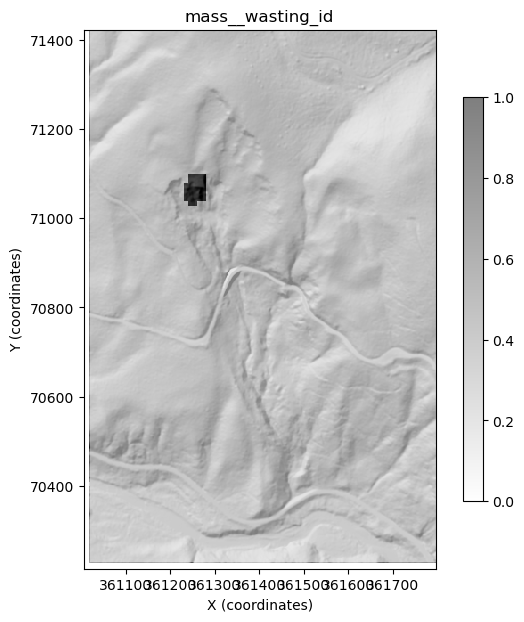

In [7]:
plt.figure()
plot_node_field_with_shaded_high_res_dem(mg, mg_hs = mg_hs, field = 'mass__wasting_id',
                                         plot_name = 'high_res', fontsize = 10,cmap = 'binary',alpha = .5, 
                                         figsize = (7,7), cbr = [0,1])

#### Look at drainage network. Notice the two roads that cross the flow path below the landslide body.

<Figure size 640x480 with 0 Axes>

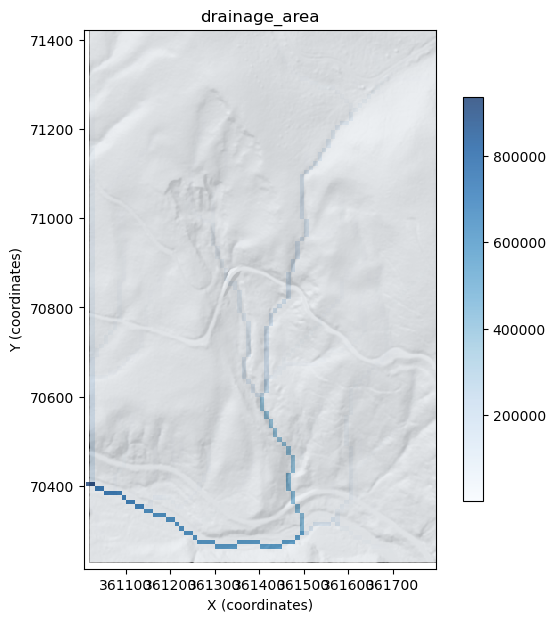

In [8]:
plt.figure()
plot_node_field_with_shaded_high_res_dem(mg, mg_hs = mg_hs, field = 'drainage_area',
                                         plot_name = 'high_res', fontsize = 10,cmap = 'Blues',alpha = .75, 
                                         figsize = (7,7))

#### look at slope. We expect deposition at lower slopes and erosion at higher slopes

<Figure size 640x480 with 0 Axes>

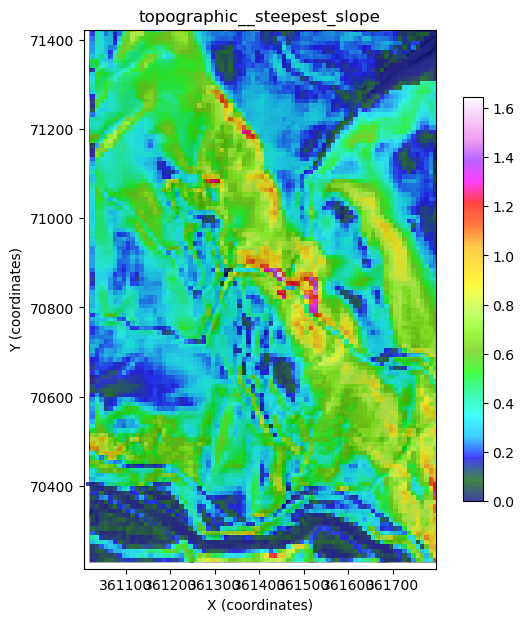

In [9]:
# visually check inputs
plt.figure()
plot_node_field_with_shaded_high_res_dem(mg, mg_hs = mg_hs, field = 'topographic__steepest_slope',
                                         plot_name = 'high_res', fontsize = 10,cmap = 'gist_ncar',alpha = .75, 
                                         figsize = (7,7), clim = [0,1])
plt.show()

In [10]:
# multiflow direction for MWRu
# need to delete d8 flow direction
mg.delete_field(loc = 'node', name = 'flow__sink_flag')
mg.delete_field(loc = 'node', name = 'flow__link_to_receiver_node')
mg.delete_field(loc = 'node', name = 'flow__receiver_node')
mg.delete_field(loc = 'node', name = 'topographic__steepest_slope')

# run flow director, add slope and receiving node fields
fd = FlowDirectorMFD(mg, diagonals=True,
                      partition_method = 'slope')
fd.run_one_step()

### view the landslide polygon before releasing the landslide

### instantiate MassWastingRunout and run it!!!!

In [11]:
# set model parameters
MWR = MassWastingRunout(grid = mg,
                        critical_slope = critical_slope,
                        threshold_flux = threshold_flux ,
                        erosion_coefficient = erosion_coefficient,      
                        tracked_attributes = tracked_attributes,
                        save = True,
                        typical_flow_thickness_of_erosion_zone = typical_flow_thickness_of_erosion_zone,
                        typical_slope_of_erosion_zone = typical_slope_of_erosion_zone,
                        max_flow_depth_observed_in_field = max_flow_depth_observed_in_field
                       )

MWR.run_one_step(run_id = 0)

 running with spatially variable Dp 


### visualize the runout

<IPython.core.display.Javascript object>


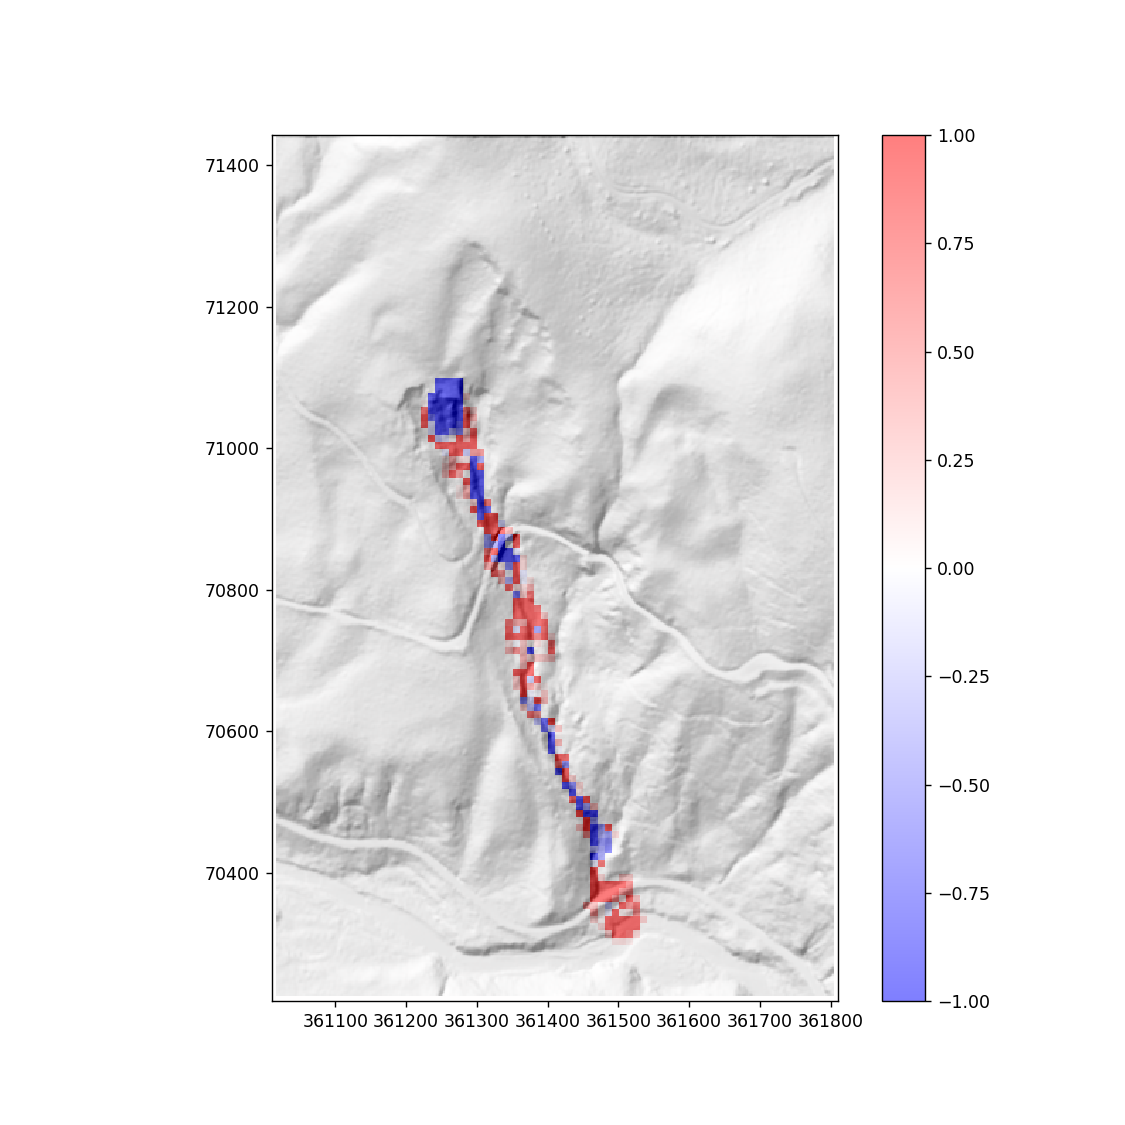

In [12]:
import gc
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.animation as animation
%matplotlib notebook


# update function
def update_plot(frame_number, MWR, plot):
    mg.at_node['dem_dif_o'] = MWR.runout_evo_maps[0][frame_number]-mg.at_node['topographic__initial_elevation']
    plot[0].set_array(mg.at_node['dem_dif_o'])
    plot[0].remove()
    plot[0] = color_mesh_vals(clim = [-1,1])

# prepare the first frame
fig = plt.figure(figsize = (9,9))
nmax=len(MWR.runout_evo_maps[0].keys())
x,y,values = get_values_xy(mg_hs, 'hillshade_arc')
myimage = plt.pcolormesh(x, y, values, cmap = 'Greys_r', alpha = 1)
myimage.set_rasterized(True)
myimage.axes.set_aspect("equal")
plt.autoscale(tight=True)
plot = [color_mesh_vals(clim = [-1,1])]
cb = plt.colorbar(norm=True)


animate_10 = animation.FuncAnimation(fig, update_plot, nmax, 
                                     fargs=(MWR, plot),
                                     blit = True, repeat = False, 
                                     cache_frame_data=False)